# Compression

In [9]:
import random
import itertools
from collections import Counter

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)


Consider a stream (sequence) of 0s and 1s of length $N$.

In [41]:
random.seed(42)
N = 10_000_000
code = random.choices(range(2), k=N)
print(code[:11])

[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]


In [3]:
def group(code: list[int]) -> list[tuple[int, int]]:
    return [(k, sum(1 for _ in g)) for k, g in itertools.groupby(code)]

def compress(code: list[int]) -> str:
    groups = group(code)
    CH_MAP = 'OI'
    return ''.join(f'{amt}{CH_MAP[ch]}' if amt > 1 else CH_MAP[ch] for ch, amt in groups)

def compress_str(string: str) -> str:
    code = list(map(int, string))
    return compress(code)

Let us use the following toy compression algorithm which replaces all repeated substrings of length $k$ (let these be called $s_k$) by "kO" (or "kI" for 1s); it drops the $k$ if $k=1$.

For example:

In [5]:
compress_str('111101101000')

'4IO2IOI3O'

Then, for our original long sequence, we have:

In [42]:
len_ = len(code)
print(f'initial length = {len_:,}')

compressed = compress(code)
print(f"compressed: {compressed[:10]}...")
len_c = len(compressed)
print(f'compressed length = {len_c:,}')
print(f'percentage of init len: {len_c/len_:.3%}')

initial length = 10,000,000
compressed: I3O3I4OI2O...
compressed length = 7,509,112
percentage of init len: 75.091%


One can see that the length (we only consider the length as our efficiency metric) decreased to about 0.75 of that of the original sequence.

In [14]:
def get_seq(len_, p_zero=0.5) -> str:
    data_list = random.choices([0, 1], weights=[p_zero, 1 - p_zero], k=len_)
    return "".join(map(str, data_list))

In [ ]:
def compression_efficiency(length: int, prob_zero: float) -> float:
    seq = get_seq(length, p_zero=prob_zero)
    compressed = compress_str(seq)
    return len(compressed) / length

In [16]:
def compression_efficiency_avg(length: int, prob_zero: float, N_samples: int = 100) -> float:
    return sum(compression_efficiency(length, prob_zero) for _ in range(N_samples)) / N_samples

Now, let us compute the average compression efficiency for long sequences.

In [25]:
compression_efficiency_avg(1_000_000, 0.5)

0.75092779

### Excurse: non-uniform 0 and 1

The average efficiency drops as we change the probability (and hence the proportion) of 0s.

In [ ]:
prob_zero_values = [0.1 * i for i in [1, 2, 3, 4, 5, 6, 7]]
N_SAMPLES = 3000

eff_10 = [compression_efficiency_avg(10, p, N_samples=N_SAMPLES) for p in prob_zero_values]
eff_100 = [compression_efficiency_avg(100, p, N_samples=N_SAMPLES) for p in prob_zero_values]
eff_1000 = [compression_efficiency_avg(1000, p, N_samples=N_SAMPLES) for p in prob_zero_values]

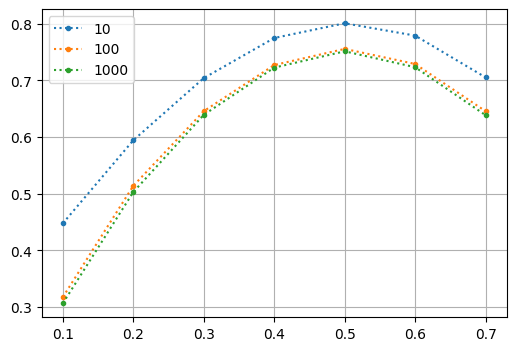

In [19]:
plt.plot(prob_zero_values, eff_10, '.:', label='10')
plt.plot(prob_zero_values, eff_100, '.:', label='100')
plt.plot(prob_zero_values, eff_1000, '.:', label='1000')
plt.grid()
plt.legend()
plt.show()

In [21]:
more_prob_values = [0.02*i for i in range(1, 30)]
more_eff_10000 = [compression_efficiency_avg(1000, p, N_samples=N_SAMPLES) for p in more_prob_values]

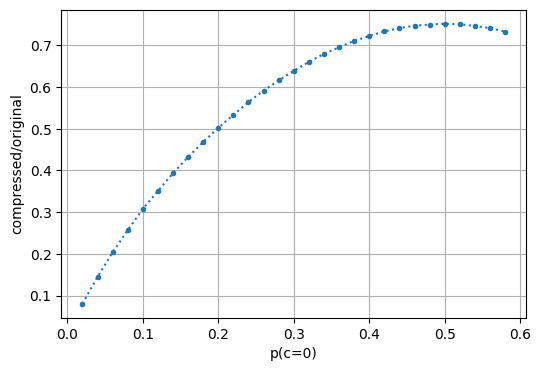

In [22]:
plt.plot(more_prob_values, more_eff_10000, '.:')
plt.xlabel('p(c=0)')
plt.ylabel('compressed/original')
plt.grid()
plt.show()

# Math

Find the expression for the compression efficiency $E(N)$ of a sequence of length $N$.

Find the limit 
$$E^* := \lim_{N\rightarrow\infty} E(N)$$

# Bit Streams Stats
Consider this problem first.

Say, how many consequent 0s or 1s of length $k$ ($s_k$) are there in a bitstream of length $N$? 

Probability that there are no $s_k$ in a bitstream of length $N$.

(Theory + simulation.)

In [43]:
groups_code = group(code)

s_k_counts = Counter(k for _, k in groups_code)


In [44]:
s_k_counts

Counter({1: 2499151,
         2: 1251041,
         3: 624187,
         4: 311556,
         5: 156484,
         6: 78364,
         7: 39259,
         8: 19846,
         9: 9629,
         10: 4898,
         11: 2434,
         12: 1173,
         13: 632,
         14: 303,
         15: 155,
         16: 72,
         17: 35,
         18: 27,
         19: 7,
         23: 3,
         21: 2,
         24: 1,
         22: 1})

In [69]:
def theoretical_count(k: int, N: int) -> float:
    return N / (2 ** (k + 1))


theoretical_counts = {k: theoretical_count(k, N) for k in sorted(s_k_counts.keys(), reverse=True)}


for k in sorted(s_k_counts):
    print(f"{k}: {s_k_counts[k]:,} {theoretical_counts[k]:,}")


1: 2,499,151 2,500,000.0
2: 1,251,041 1,250,000.0
3: 624,187 625,000.0
4: 311,556 312,500.0
5: 156,484 156,250.0
6: 78,364 78,125.0
7: 39,259 39,062.5
8: 19,846 19,531.25
9: 9,629 9,765.625
10: 4,898 4,882.8125
11: 2,434 2,441.40625
12: 1,173 1,220.703125
13: 632 610.3515625
14: 303 305.17578125
15: 155 152.587890625
16: 72 76.2939453125
17: 35 38.14697265625
18: 27 19.073486328125
19: 7 9.5367431640625
21: 2 2.384185791015625
22: 1 1.1920928955078125
23: 3 0.5960464477539062
24: 1 0.2980232238769531


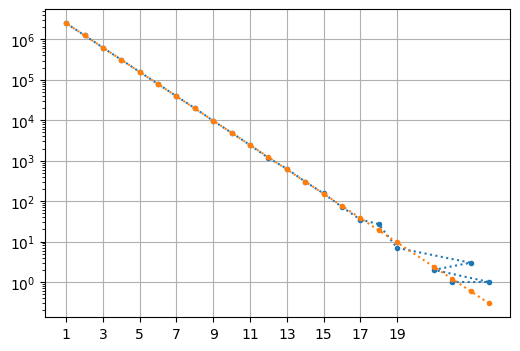

In [71]:
plt.plot(*zip(*s_k_counts.most_common()), '.:')
plt.plot(*zip(*theoretical_counts.items()), '.:')

plt.xticks(range(1, 20, 2))
plt.yscale('log')
plt.grid()
plt.show()